In [1]:
import json
import os
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pyximport
pyximport.install(language_level=3)

from config import train_graphs_json_path
from config import kb_pairwise_json_path
from semantic_analysis.knowledge_base import filter_kb_histograms, get_sup_ent_lists
from panopticapi.utils import load_png_annotation
from semantic_analysis.visualization import RelationshipVisualizer, filter_graphs_with_local_data
import cv2

with open(kb_pairwise_json_path, 'r') as f:
    json_data = json.load(f)
with open(train_graphs_json_path, "r") as f:
    tot_graphs = json.load(f)
    
entr3 = entropy([1/3,1/3,1/3])
minsup = 64
filtered_kb = filter_kb_histograms(json_data, minsup, entr3)
sup_filtered, ent_filtered = get_sup_ent_lists(filtered_kb)

graphs = filter_graphs_with_local_data(tot_graphs)

In [2]:
def get_graph(graphs, graph_id):
    for g in graphs:
        name = g['graph']['name']
        if name==selected:
            return g
    return None
def get_distance(g1, g2):
    n1 = set([n['label'] for n in g1['nodes']])
    n2 = set([n['label'] for n in g2['nodes']])
    return -len(n1 & n2) #+ 0.25*abs(len(g1['nodes'])-len(g2['nodes']))

In [3]:

selected = 36841
g_sel = get_graph(graphs, selected)

best_dist = None
best_g = None
for g in graphs:
    name = g['graph']['name']
    if name!=selected:
        dist = get_distance(g_sel, g)
        if best_dist==None or dist<best_dist:
            best_dist = dist
            best_g = g
            
best_id = best_g['graph']['name']


In [4]:
def print_images(selected, best_ids):
    image_ids = [selected]+ best_ids
    plt.figure(figsize=[14,18])
    for i, image_id in enumerate(image_ids):
        for g in graphs:
            if g['graph']['name']==image_id:
                break
        ax = plt.subplot(3,2,i+1)
        rv = RelationshipVisualizer(g['graph']['name'], ax)
        rv.draw_positive_relationships(g, filtered_kb, 0.1)

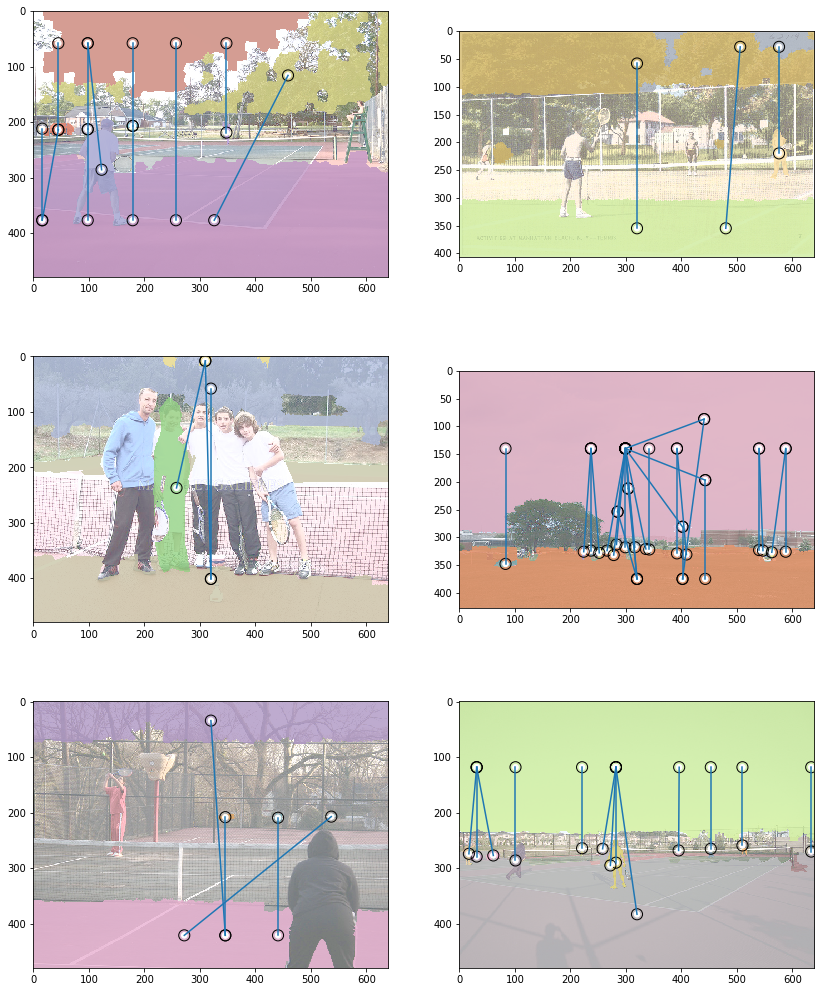

In [5]:
# sel = 36841
# 499966 (no filter)
# 499966 filter >0.1
# 499966 filter >0.5
# sel = 499952
# [30247, 499884, 149, 419, 531] filter >0.1
selected = 499952
best_ids = [30247, 499884, 149, 419, 531]
print_images(selected, best_ids)

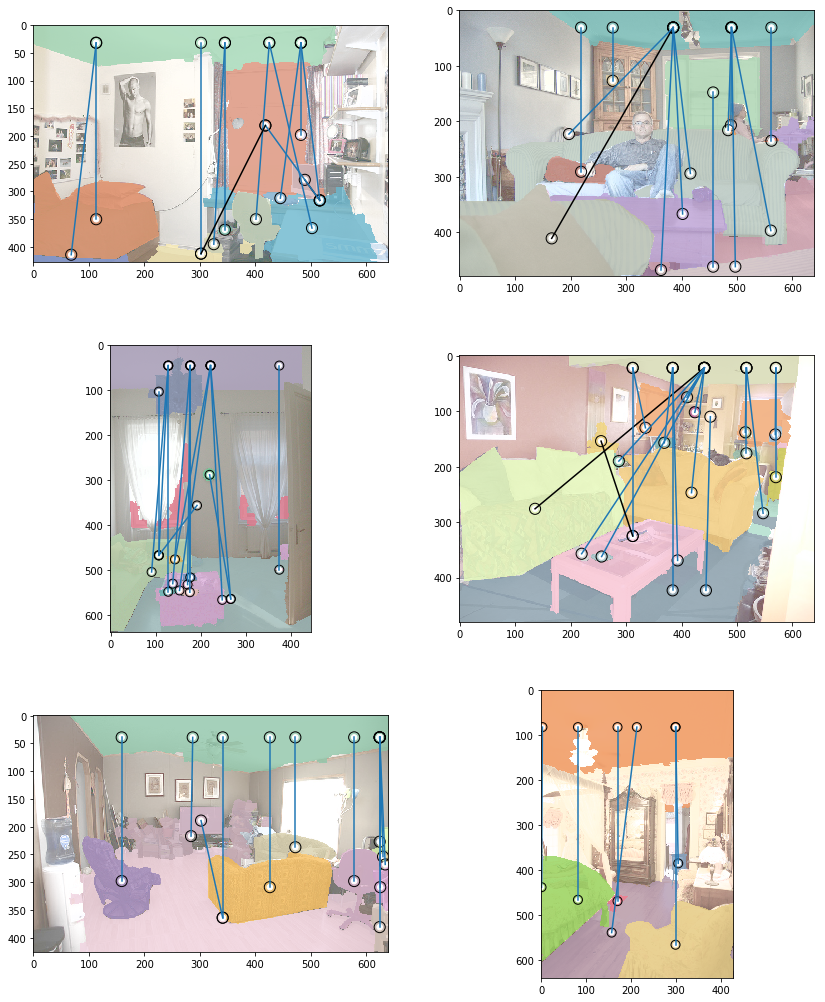

In [6]:
selected = 36841
best_ids = [499966, 384, 711, 762, 30434]
print_images(selected, best_ids)

In [105]:
with open('../COCO/annotations/bison_annotations.cocoval2014.json', 'r') as f:
    bison = json.load(f)
with open('../COCO/annotations/panoptic_val2017.json', 'r') as f:
    panval17 = json.load(f)
with open('../COCO/annotations/panoptic_train2017.json', 'r') as f:
    pantrain17 = json.load(f)
pan17val_ids={img['id'] for img in panval17['images']}
pan17train_ids={img['id'] for img in pantrain17['images']}

bison_map = {}

for sample in bison['data']:
    a,b = [int(img['image_filename'].split('_')[-1].split('.')[0]) for img in sample['image_candidates']]
   
    if a in pan17val_ids and b in pan17val_ids:
        if a in bison_map:
            bison_map[a].add(b)
        else:
            bison_map[a]={b}
        if b in bison_map:
            bison_map[b].add(a)
        else:
            bison_map[b]={a}

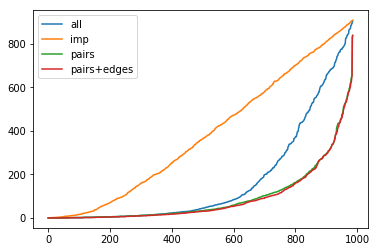

In [147]:
with open('../COCO/anomalies/positions.json','r') as f:
    ranks = json.load(f)
with open('../COCO/anomalies/positions_impEdges.json','r') as f:
    ranksImp = json.load(f)
with open('../COCO/anomalies/positions_pairs.json','r') as f:
    ranksPairs = json.load(f)
with open('../COCO/anomalies/positions_PairEdges.json','r') as f:
    ranksPairEdges = json.load(f)
    
# Esperimento con tutti gli archi
plt.plot(sorted(ranks), label="all")
# Esperimento con archi importanti
plt.plot(sorted(ranksImp), label="imp")
# Esperimento con solo oggetti
plt.plot(sorted(ranksPairs), label="pairs")
# Esperimento con oggetti e tutti gli archi
plt.plot(sorted(ranksPairEdges), label="pairs+edges")
plt.legend()

In [152]:
import numpy as np
print(np.array(ranks).mean())
print(np.array(ranksPairs).mean())
print(np.array(ranksPairEdges).mean())

171.76470588235293
93.14908722109533
89.40669371196755


In [130]:
list(bison_map.items())[4]

(101884, {312263})

In [80]:
len(bison['data'])

54253

In [66]:
bison_ids = []
for sample in bison['data']:
    bison_ids.extend([int(img['image_filename'].split('_')[-1].split('.')[0]) for img in sample['image_candidates']])
bison_ids = set(bison_ids)
pan17train_ids={g['graph']['name'] for g in tot_graphs}
pan17val_ids=[img['id'] for img in pan17['images']]

In [70]:
count=0
for imgid in pan17train_graphs:
    if imgid in bison_ids:
        count+=1
print(count)
print(len(pan17train_graphs))


count=0
for imgid in pan17val_ids:
    if imgid in bison_ids:
        count+=1
print(count)
print(len(pan17val_ids))

33914
118267
4760
5000


FileNotFoundError: [Errno 2] No such file or directory: '../COCO/annotations/panoptic_train2017/000000417023.png'

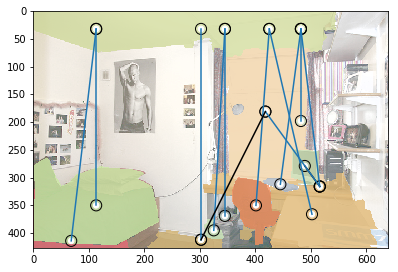

In [40]:
selected = 36841
best_ids = [417023, 248300]
print_images(selected, best_ids)

In [ ]:
%load_ext autoreload
%autoreload


pick_hist = np.array(ent_filtered).argsort()[4]
picked_pair, picked_hist = list(filtered_kb.items())[pick_hist]
picked_pair = convert_pair(picked_pair)
print(picked_pair, clean_histogram(picked_hist))


def graph_satisfy(graph, pair, histogram):
    maxp = -1
    # Create map with node labels
    node_labels = {n['id'] : n['label'] for n in graph['nodes']}
    hist = {}
    for l in graph['links']:
        s = node_labels[l['s']]
        r = node_labels[l['r']]
        pos = l['pos']
        if s==pair[0] and r==pair[1]:
            try:
                p = histogram[pos]
                if p > maxp:
                    maxp=p
            except:
                pass
    return maxp

tot=0
for i, g in enumerate(graphs):
    p = graph_satisfy(g, picked_pair, picked_hist)
    if p>0.0 and tot<10:
        tot+=1
        img_file = getImageName(g['graph']['name'], COCO_img_train_dir, 'jpg')
        img = Image.open(img_file)
        plt.figure()
        plt.imshow(img)
        print(img_file)
    elif tot>=10:
        break
